In [1]:
!pip install spotipy

In [2]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

## 1. Data Exploration/Preparation

Dataset:
https://www.kaggle.com/code/vatsalmavani/music-recommendation-system-using-spotify-dataset/input

In [11]:
spotify_df = pd.read_csv('data.csv')

In [13]:
spotify_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

In [15]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

genres                                            artists  \
0  ['show tunes']                   "Cats" 1981 Original London Cast   
1              []                          "Cats" 1983 Broadway Cast   
2              []        "Fiddler On The Roof” Motion Picture Chorus   
3              []     "Fiddler On The Roof” Motion Picture Orchestra   
4              []  "Joseph And The Amazing Technicolor Dreamcoat"...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210389  117.518111  0.389500   38.333333    5   
1  0.315215 -10.690000     0.176212  103.044154  0.268865   30.576923    5   
2  0.325786 -15.230714     0.118514   77.375857  0.354857   34.857143    0   
3  0.275481 -15.639370     0.123200   88.667630  0.372030   34.851852    0   
4  0.195000 -10.236714     0.098543  122.835857  0.482286   43.000000    5   

   mode  count  
0     1      9  
1     1     26  
2     1      7  
3     1     27  
4     1      7

In [17]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [19]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [21]:
data_w_genre['genres'].values[0][0]

'['

It's actually a string that looks like a list.
Below is a regex statement to extract the genre and input into a list

In [24]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [26]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [28]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [30]:
spotify_df['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [32]:
spotify_df['artists_upd_v1'].values[0][0]

'Sergei Rachmaninoff'

In [34]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

valence  year  acousticness                             artists  \
143    0.300  1921         0.772                ["Scarlet D'Carpio"]   
234    0.902  1923         0.994  ["King Oliver's Creole Jazz Band"]   
238    0.554  1923         0.996  ["King Oliver's Creole Jazz Band"]   
244    0.319  1923         0.995    ["Clarence Williams' Blue Five"]   
249    0.753  1923         0.994  ["King Oliver's Creole Jazz Band"]   

     danceability  duration_ms  energy  explicit                      id  \
143         0.560       249370   0.313         0  7b4eHImKQ51DYaQvNTdtEp   
234         0.708       194533   0.361         0  1xEEYhWxT4WhDQdxfPCT8D   
238         0.546       170827   0.189         0  3rauXVLOOM5BlxWqUcDpkg   
244         0.520       197493   0.153         0  1UdqHVRFYMZKU2Q7xkLtYc   
249         0.359       187227   0.357         0  5SvyP1ZeJX1jA7AOZD08NA   

     instrumentalness  key  liveness  loudness  mode                     name  \
143          0.000005    6     0.115    -8.346     0  Himno Nacional del Perú   
234          0.883000    0     0.103   -11.764     0                Snake Rag   
238          0.908000    0     0.339   -15.984     1             Chimes Blues   
244          0.131000    0     0.353   -14.042     1     Pickin' On Your Baby   
249          0.819000    3     0.290   -11.810     1                    Tears   

     popularity release_date  speechiness    tempo artists_upd_v1  
143           0   1921-09-23       0.0376  107.501             []  
234          20         1923       0.0441  105.695             []  
238          13         1923       0.0581   80.318             []  
244          11         1923       0.0440  102.937             []  
249          10         1923       0.0511  205.053             []

In [36]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [38]:
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [39]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [41]:
spotify_df[spotify_df['name']=='Adore You']

valence  year  acousticness           artists  danceability  \
19425    0.569  2019        0.0237  ['Harry Styles']         0.676   
38319    0.569  2019        0.0237  ['Harry Styles']         0.676   

       duration_ms  energy  explicit                      id  \
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7   
38319       207133   0.771         0  1M4qEo4HE3PRaCOM7EXNJq   

       instrumentalness  key  liveness  loudness  mode       name  popularity  \
19425          0.000007    8     0.102    -3.675     1  Adore You          88   
38319          0.000007    8     0.102    -3.675     1  Adore You          77   

      release_date  speechiness   tempo  artists_upd_v1 artists_upd_v2  \
19425   2019-12-13       0.0483  99.048  [Harry Styles]             []   
38319   2019-12-06       0.0483  99.048  [Harry Styles]             []   

          artists_upd           artists_song  
19425  [Harry Styles]  Harry StylesAdore You  
38319  [Harry Styles]  Harry StylesAdore You

In [44]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [46]:
spotify_df[spotify_df['name']=='Adore You']

valence  year  acousticness           artists  danceability  \
19425    0.569  2019        0.0237  ['Harry Styles']         0.676   

       duration_ms  energy  explicit                      id  \
19425       207133   0.771         0  3jjujdWJ72nww5eGnfs2E7   

       instrumentalness  key  liveness  loudness  mode       name  popularity  \
19425          0.000007    8     0.102    -3.675     1  Adore You          88   

      release_date  speechiness   tempo  artists_upd_v1 artists_upd_v2  \
19425   2019-12-13       0.0483  99.048  [Harry Styles]             []   

          artists_upd           artists_song  
19425  [Harry Styles]  Harry StylesAdore You

In [48]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [50]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [52]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='3jjujdWJ72nww5eGnfs2E7']

artists_upd                      id                    genres  \
126973  Harry Styles  3jjujdWJ72nww5eGnfs2E7  ['pop', 'post-teen pop']   

             artists  acousticness  danceability    duration_ms    energy  \
126973  Harry Styles      0.268816      0.541462  238180.230769  0.586769   

        instrumentalness  liveness  loudness  speechiness    tempo   valence  \
126973          0.016809  0.156208 -6.386923     0.035888  114.687  0.406896   

        popularity  key  mode  count            genres_upd  
126973   78.346154  5.0   1.0   52.0  [pop, post-teen_pop]

In [58]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [59]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [60]:
artists_genres_consolidated.head()

id                                         genres_upd  \
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_wave, new_wave_po...   
1  000GyYHG4uWmlXieKLij8u  [[alternative_hip_hop, conscious_hip_hop, minn...   
2  000Npgk5e2SgwGaIsN3ztv  [[classic_bollywood, classic_pakistani_pop, fi...   
3  000ZxLGm7jDlWCHtcXSeBe    [[boogie-woogie, piano_blues, ragtime, stride]]   
4  000jBcNljWTnyjB4YO7ojf                                               [[]]   

                            consolidates_genre_lists  
0  [dance_rock, new_wave_pop, candy_pop, power_po...  
1  [pop_rap, alternative_hip_hop, conscious_hip_h...  
2  [classic_pakistani_pop, classic_bollywood, fil...  
3      [ragtime, boogie-woogie, piano_blues, stride]  
4                                                 []

In [64]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

In [66]:
spotify_df.tail()

valence  year  acousticness  \
156602    0.768  1997        0.2820   
156603    0.792  2004        0.0248   
156604    0.697  1999        0.0516   
156605    0.429  1994        0.0249   
156606    0.273  1996        0.0113   

                                               artists  danceability  \
156602                      ["Lil' Kim", "Lil' Cease"]         0.748   
156603                            ["Lil' Flip", 'Lea']         0.814   
156604  ["Ol' Dirty Bastard", 'Kelis', 'Rich Travali']         0.934   
156605      ["World Class Wreckin' Cru", "Michel 'Le"]         0.715   
156606      ["Rappin' 4-Tay", 'MC Breed', 'Too $hort']         0.897   

        duration_ms  energy  explicit                      id  \
156602       275947   0.693         0  2LP2uDQQ7eLMcUVE4aOpAV   
156603       225173   0.387         1  4s0o8TJHfX9LLHa0umnOzT   
156604       239547   0.459         1  6YYd5MLpu45J0uLrMdivF7   
156605       351040   0.490         0  3hoiinUc5VA9xUEJID7R8V   
156606       337973   0.414         1  78859Af0fmA9VTlgnOHTAP   

        instrumentalness  key  liveness  loudness  mode  \
156602           0.00000   11     0.123    -7.832     0   
156603           0.00000    0     0.131    -9.867     1   
156604           0.00000    1     0.222    -7.654     1   
156605           0.00017    9     0.139    -9.504     0   
156606           0.00011    4     0.101    -8.450     0   

                                           name  popularity release_date  \
156602  Crush on You (feat. Lil' Cease) - Remix          56   1997-06-30   
156603                     Sunshine (feat. Lea)          62   2004-03-30   
156604             Got Your Money (feat. Kelis)          66         1999   
156605                Turn Off The Lights - Rap          36   1994-04-06   
156606                          Never Talk Down          35         1996   

        speechiness    tempo           artists_upd_v1  \
156602       0.2780   88.802            [ Kim", "Lil]   
156603       0.0945   93.961               [ Flip", ]   
156604       0.1890  103.040  [ Dirty Bastard", , , ]   
156605       0.0479  129.309        [ Cru", "Michel ]   
156606       0.2460   96.039          [ 4-Tay", , , ]   

                                artists_upd_v2              artists_upd  \
156602                  [Lil' Kim, Lil' Cease]            [ Kim", "Lil]   
156603                             [Lil' Flip]               [ Flip", ]   
156604                     [Ol' Dirty Bastard]  [ Dirty Bastard", , , ]   
156605  [World Class Wreckin' Cru, Michel 'Le]        [ Cru", "Michel ]   
156606                         [Rappin' 4-Tay]          [ 4-Tay", , , ]   

                                             artists_song  \
156602   Kim", "LilCrush on You (feat. Lil' Cease) - R...   
156603                        Flip", Sunshine (feat. Lea)   
156604       Dirty Bastard", Got Your Money (feat. Kelis)   
156605            Cru", "Michel Turn Off The Lights - Rap   
156606                            4-Tay", Never Talk Down   

       consolidates_genre_lists  
156602                      NaN  
156603                      NaN  
156604                      NaN  
156605                      NaN  
156606                      NaN

In [68]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [70]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [72]:
ohe_cols = 'popularity'

In [74]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [76]:
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [78]:
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else []) 

In [80]:
spotify_df.head()

valence  year  acousticness         artists  danceability  duration_ms  \
0    0.177  1989         0.568         ['조정현']         0.447       237688   
1    0.352  1992         0.381          ['黑豹']         0.353       316160   
2    0.458  1963         0.987         ['黃國隆']         0.241       193480   
3    0.796  1963         0.852  ['黃國隆', '王秋玉']         0.711       145720   
4    0.704  1963         0.771         ['黃國隆']         0.610       208760   

   energy  explicit                      id  instrumentalness  key  liveness  \
0  0.2150         0  2ghebdwe2pNXT4eL34T7pW          0.000001   10    0.0649   
1  0.6860         0  3KIuCzckjdeeVuswPo20mC          0.000000   11    0.0568   
2  0.0437         0  4prhqrLXYMjHJ6vpRAlasx          0.000453    5    0.2650   
3  0.1110         0  5xFXTvnEe03SyvFpo6pEaE          0.000000    2    0.0695   
4  0.1750         0  6Pqs2suXEqCGx7Lxg5dlrB          0.000000    7    0.0309   

   loudness  mode                  name  popularity release_date  speechiness  \
0   -16.478     1            그아픔까지사랑한거야          31   1989-06-15       0.0272   
1    -9.103     1  DON'T BREAK MY HEART          35   1992-12-22       0.0395   
2   -24.571     1                   藝旦調          23   1963-05-28       0.0443   
3   -20.741     0                 草螟弄雞公          23   1963-05-28       0.0697   
4   -20.232     1                   思想起          23   1963-05-28       0.0419   

     tempo artists_upd_v1 artists_upd_v2 artists_upd            artists_song  \
0   71.979          [조정현]             []       [조정현]           조정현그아픔까지사랑한거야   
1  200.341           [黑豹]             []        [黑豹]  黑豹DON'T BREAK MY HEART   
2   85.936          [黃國隆]             []       [黃國隆]                  黃國隆藝旦調   
3  124.273     [黃國隆, 王秋玉]             []  [黃國隆, 王秋玉]                黃國隆草螟弄雞公   
4  124.662          [黃國隆]             []       [黃國隆]                  黃國隆思想起   

              consolidates_genre_lists  popularity_red  
0                 [classic_korean_pop]               6  
1  [chinese_indie_rock, chinese_indie]               7  
2                                   []               4  
3                                   []               4  
4                                   []               4

In [82]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    
    tf_df = pd.get_dummies(df[column]) #One hot encoded features 
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [84]:
#function to build entire feature set
def create_feature_set(df, float_cols):    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [86]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [87]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house  \
0                     0.0              0.0              0.0               0.0   
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   genre|acid_rock  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0              0.0                0.0               0.0             0.0   
1              0.0                0.0               0.0             0.0   
2              0.0                0.0               0.0             0.0   
3              0.0                0.0               0.0             0.0   
4              0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_pop  genre|acoustic_punk  \
0                   0.0                 0.0                  0.0   
1                   0.0                 0.0                  0.0   
2                   0.0                 0.0                  0.0   
3                   0.0                 0.0                  0.0   
4                   0.0                 0.0                  0.0   

   genre|acoustic_rock  genre|action_rock  genre|adoracion  \
0                  0.0                0.0              0.0   
1                  0.0                0.0              0.0   
2                  0.0                0.0              0.0   
3                  0.0                0.0              0.0   
4                  0.0                0.0              0.0   

   genre|adult_standards  genre|adventista  genre|afghan_pop  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   

   genre|afghan_traditional  genre|african  genre|african_percussion  \
0                       0.0            0.0                       0.0   
1                       0.0            0.0                       0.0   
2                       0.0            0.0                       0.0   
3                       0.0            0.0                       0.0   
4                       0.0            0.0                       0.0   

   genre|african_reggae  genre|african_rock  genre|afro  genre|afro_dancehall  \
0                   0.0                 0.0         0.0                   0.0   
1                   0.0                 0.0         0.0                   0.0   
2                   0.0                 0.0         0.0                   0.0   
3                   0.0                 0.0         0.0                   0.0   
4                   0.0                 0.0         0.0                   0.0   

   genre|afro_house  genre|afro_psych  genre|afro_soul  genre|afrobeat  \
0               0.0               0.0              0.0             0.0   
1               0.0               0.0              0.0             0.0   
2   

## 3. Connect to Spotify API

In [88]:
#client id and secret for my application
client_id = '034b99d1a0f54410ba81ef97cd6dffe0'
client_secret= 'f3289a94945341fbbc5481163c33cb9e'

In [89]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [90]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [91]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [92]:
sp = spotipy.Spotify(auth=token)

In [93]:
#client id and secret for my application
client_id = 'id'
client_secret= 'secret'

In [94]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [96]:
id_name

{'On Repeat': '37i9dQZF1EpmGSjooJNVUN',
 'Peace': '0MUj7asg0SyTKAeUKu7rog',
 'bollyrush': '0feDXzmKOn9cUemPIB8PEx',
 'instrumentals': '6EUr8zADjTc3N48UvGZgzA',
 'Workout Beastmode': '50tv5QvHEvGdS5MRfFL1C8',
 'Hype': '0RUuJlomrcoSCOh9D2NuQS',
 'Chill': '3Exkh1CTbmnLgjTnImFI8P',
 'Coffee and Piano': '37i9dQZF1DX3TPMgP3ojGS'}

In [99]:
def create_necessary_outputs(playlist_name,id_dic, df):
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [98]:
id_name

{'On Repeat': '37i9dQZF1EpmGSjooJNVUN',
 'Peace': '0MUj7asg0SyTKAeUKu7rog',
 'bollyrush': '0feDXzmKOn9cUemPIB8PEx',
 'instrumentals': '6EUr8zADjTc3N48UvGZgzA',
 'Workout Beastmode': '50tv5QvHEvGdS5MRfFL1C8',
 'Hype': '0RUuJlomrcoSCOh9D2NuQS',
 'Chill': '3Exkh1CTbmnLgjTnImFI8P',
 'Coffee and Piano': '37i9dQZF1DX3TPMgP3ojGS'}

In [111]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [113]:
playlist = create_necessary_outputs('On Repeat', id_name,spotify_df)

In [115]:
playlist = create_necessary_outputs('On Repeat', id_name,spotify_df)

from skimage import io
import matplotlib.pyplot as plt
import math

def visualize_songs(df):
    
    temp = df['url'].values
    plt.figure(figsize=(15, int(0.625 * len(temp))))
    columns = 5
    
    # Calculate the number of rows and round up
    rows = math.ceil(len(temp) / columns)
    
    for i, url in enumerate(temp):
        plt.subplot(rows, columns, i + 1)  # Ensure rows is an integer

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color='w', fontsize=0.1)
        plt.yticks(color='w', fontsize=0.1)
        plt.xlabel(df['name'].values[i], fontsize=12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [117]:
playlist

artist                                               name  \
0          keshi                                             2 soon   
3          SHAUN  Way Back Home (feat. Conor Maynard) - Sam Feld...   
4          keshi                     i swear i'll never leave again   
20         keshi                                          skeletons   
28  Why Don't We                                          8 Letters   

                        id                                                url  \
0   5SlU0Yhi51jobhEiGE4xDv  https://i.scdn.co/image/ab67616d00001e02d2cd26...   
3   1ZLrDPgR7mvuTco3rQK8Pk  https://i.scdn.co/image/ab67616d00001e02919944...   
4   5byXSKd7QOHtVMOiptklBD  https://i.scdn.co/image/ab67616d00001e0294237b...   
20  2BuJrxYKhYky20dQqTlobO  https://i.scdn.co/image/ab67616d00001e0244ce5e...   
28  4zRZAmBQP8vhNPf9i9opXt  https://i.scdn.co/image/ab67616d00001e02b503cd...   

                  date_added  
0  2024-09-05 17:28:23+00:00  
3  2024-09-05 17:28:23+00:00  
4  2024-09-05 17:28:23+00:00  
20 2024-09-05 17:28:23+00:00  
28 2024-09-05 17:28:23+00:00

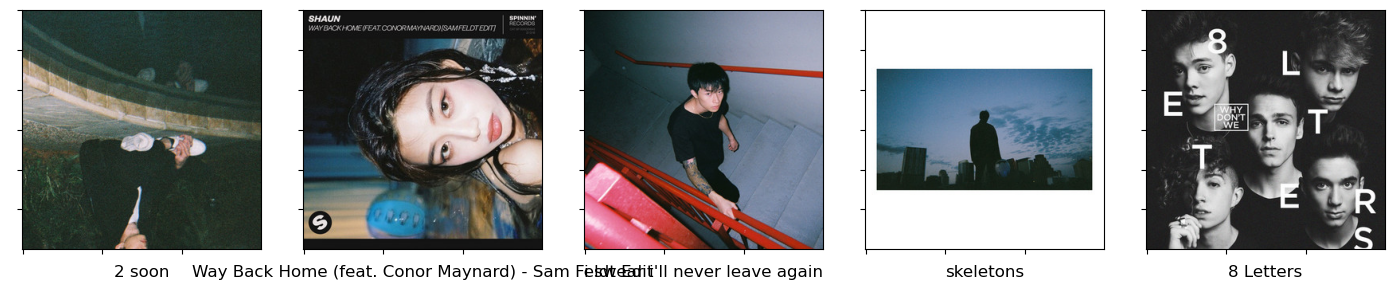

In [119]:
visualize_songs(playlist)

## 4. Create Playlist Vector

In [146]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """
    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [148]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [150]:
complete_feature_set_playlist_vector.shape

(3070,)

## 5. Generate Recommendations

In [152]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [154]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

In [155]:
edm_top40

valence  year  acousticness                          artists  \
118766    0.507  2018        0.5710                       ['Ellise']   
152980    0.551  2018        0.3880                ['Alec Benjamin']   
152981    0.474  2018        0.6550                ['Alec Benjamin']   
29874     0.419  2018        0.6260                ['Summer Walker']   
29876     0.141  2018        0.6370                ['Summer Walker']   
143438    0.187  2018        0.9210                ['Billie Eilish']   
90676     0.707  2018        0.8360                ['Jeremy Zucker']   
29873     0.123  2018        0.5580                ['Summer Walker']   
39223     0.556  2018        0.4050                        ['SHAUN']   
3723      0.412  2018        0.3990                        ['keshi']   
152988    0.409  2018        0.7740                ['Alec Benjamin']   
152987    0.861  2018        0.6980                ['Alec Benjamin']   
143436    0.177  2018        0.6930                ['Billie Eilish']   
152990    0.851  2018        0.2240                ['Alec Benjamin']   
96437     0.821  2018        0.2410                           ['IU']   
152985    0.483  2018        0.7400                ['Alec Benjamin']   
152989    0.277  2018        0.8060                ['Alec Benjamin']   
148365    0.588  2018        0.1690                     ['Ashnikko']   
113454    0.695  2018        0.4800          ['Forrest.', 'Biskwiq']   
67494     0.123  2018        0.6600                ['Maggie Rogers']   
29864     0.117  2018        0.8940                ['Summer Walker']   
113455    0.859  2018        0.2130  ['Forrest.', 'Biskwiq', 'Ryce']   
90673     0.608  2018        0.6070                ['Jeremy Zucker']   
113453    0.822  2018        0.0244          ['Forrest.', 'Biskwiq']   
132416    0.356  2018        0.0589             ['Christian French']   
29867     0.403  2019        0.7000                ['Summer Walker']   
63481     0.783  2019        0.4880             ['Melanie Martinez']   
63460     0.532  2019        0.2700             ['Melanie Martinez']   
63475     0.434  2019        0.4040             ['Melanie Martinez']   
63486     0.772  2019        0.4200             ['Melanie Martinez']   
63471     0.556  2019        0.3130             ['Melanie Martinez']   
67501     0.282  2019        0.2100                ['Maggie Rogers']   
67502     0.178  2019        0.4110                ['Maggie Rogers']   
29877     0.339  2019        0.2500                ['Summer Walker']   
39099     0.365  2019        0.8540                         ['SYML']   
143430    0.572  2019        0.7240                ['Billie Eilish']   
150293    0.695  2019        0.1770                 ['Ant Saunders']   
3817      0.691  2019        0.8010                        ['gnash']   
143425    0.563  2019        0.3500                ['Billie Eilish']   
63476     0.440  2019        0.4530             ['Melanie Martinez']   

        danceability  duration_ms  energy  explicit                      id  \
118766         0.698       190000   0.611         1  3bHZeMMosfnAS633rWpf09   
152980         0.723       218893   0.504         0  4IhKLu7Vk3j2TLmnFPl6To   
152981         0.416       188851   0.649         0  2W0AJEbIC2vdZTV2nVSAsg   
29874          0.646        92093   0.335         1  3LfHBTYZBTqmz43tvVXJBd   
29876          0.693       203240   0.369         0  5Tp4UJvnsF4Zd05k0zXUte   
143438         0.778       176472   0.422         1  5t3Vk8bRKylx4fjj7qlbib   
90676          0.773       169973   0.437         1  75ls0gurX68lUmMjE7QcsE   
29873          0.645       140760   0.418         1  644rGY6maSElnKVsAg1gJj   
39223          0.745       214137   0.739         0  3NxuezMdSLgt4OwHzBoUhL   
3723           0.748       182679   0.465         1  7ivYWXqrPLs66YwakDuSim   
152988         0.514       185123   0.605         0  0WHi11uzahqpEtPGYCW6oQ   
152987         0.656       181522   0.577         0  7pT6WSg4PCt4mr5ZFyUfsF   
143436         0.640       2

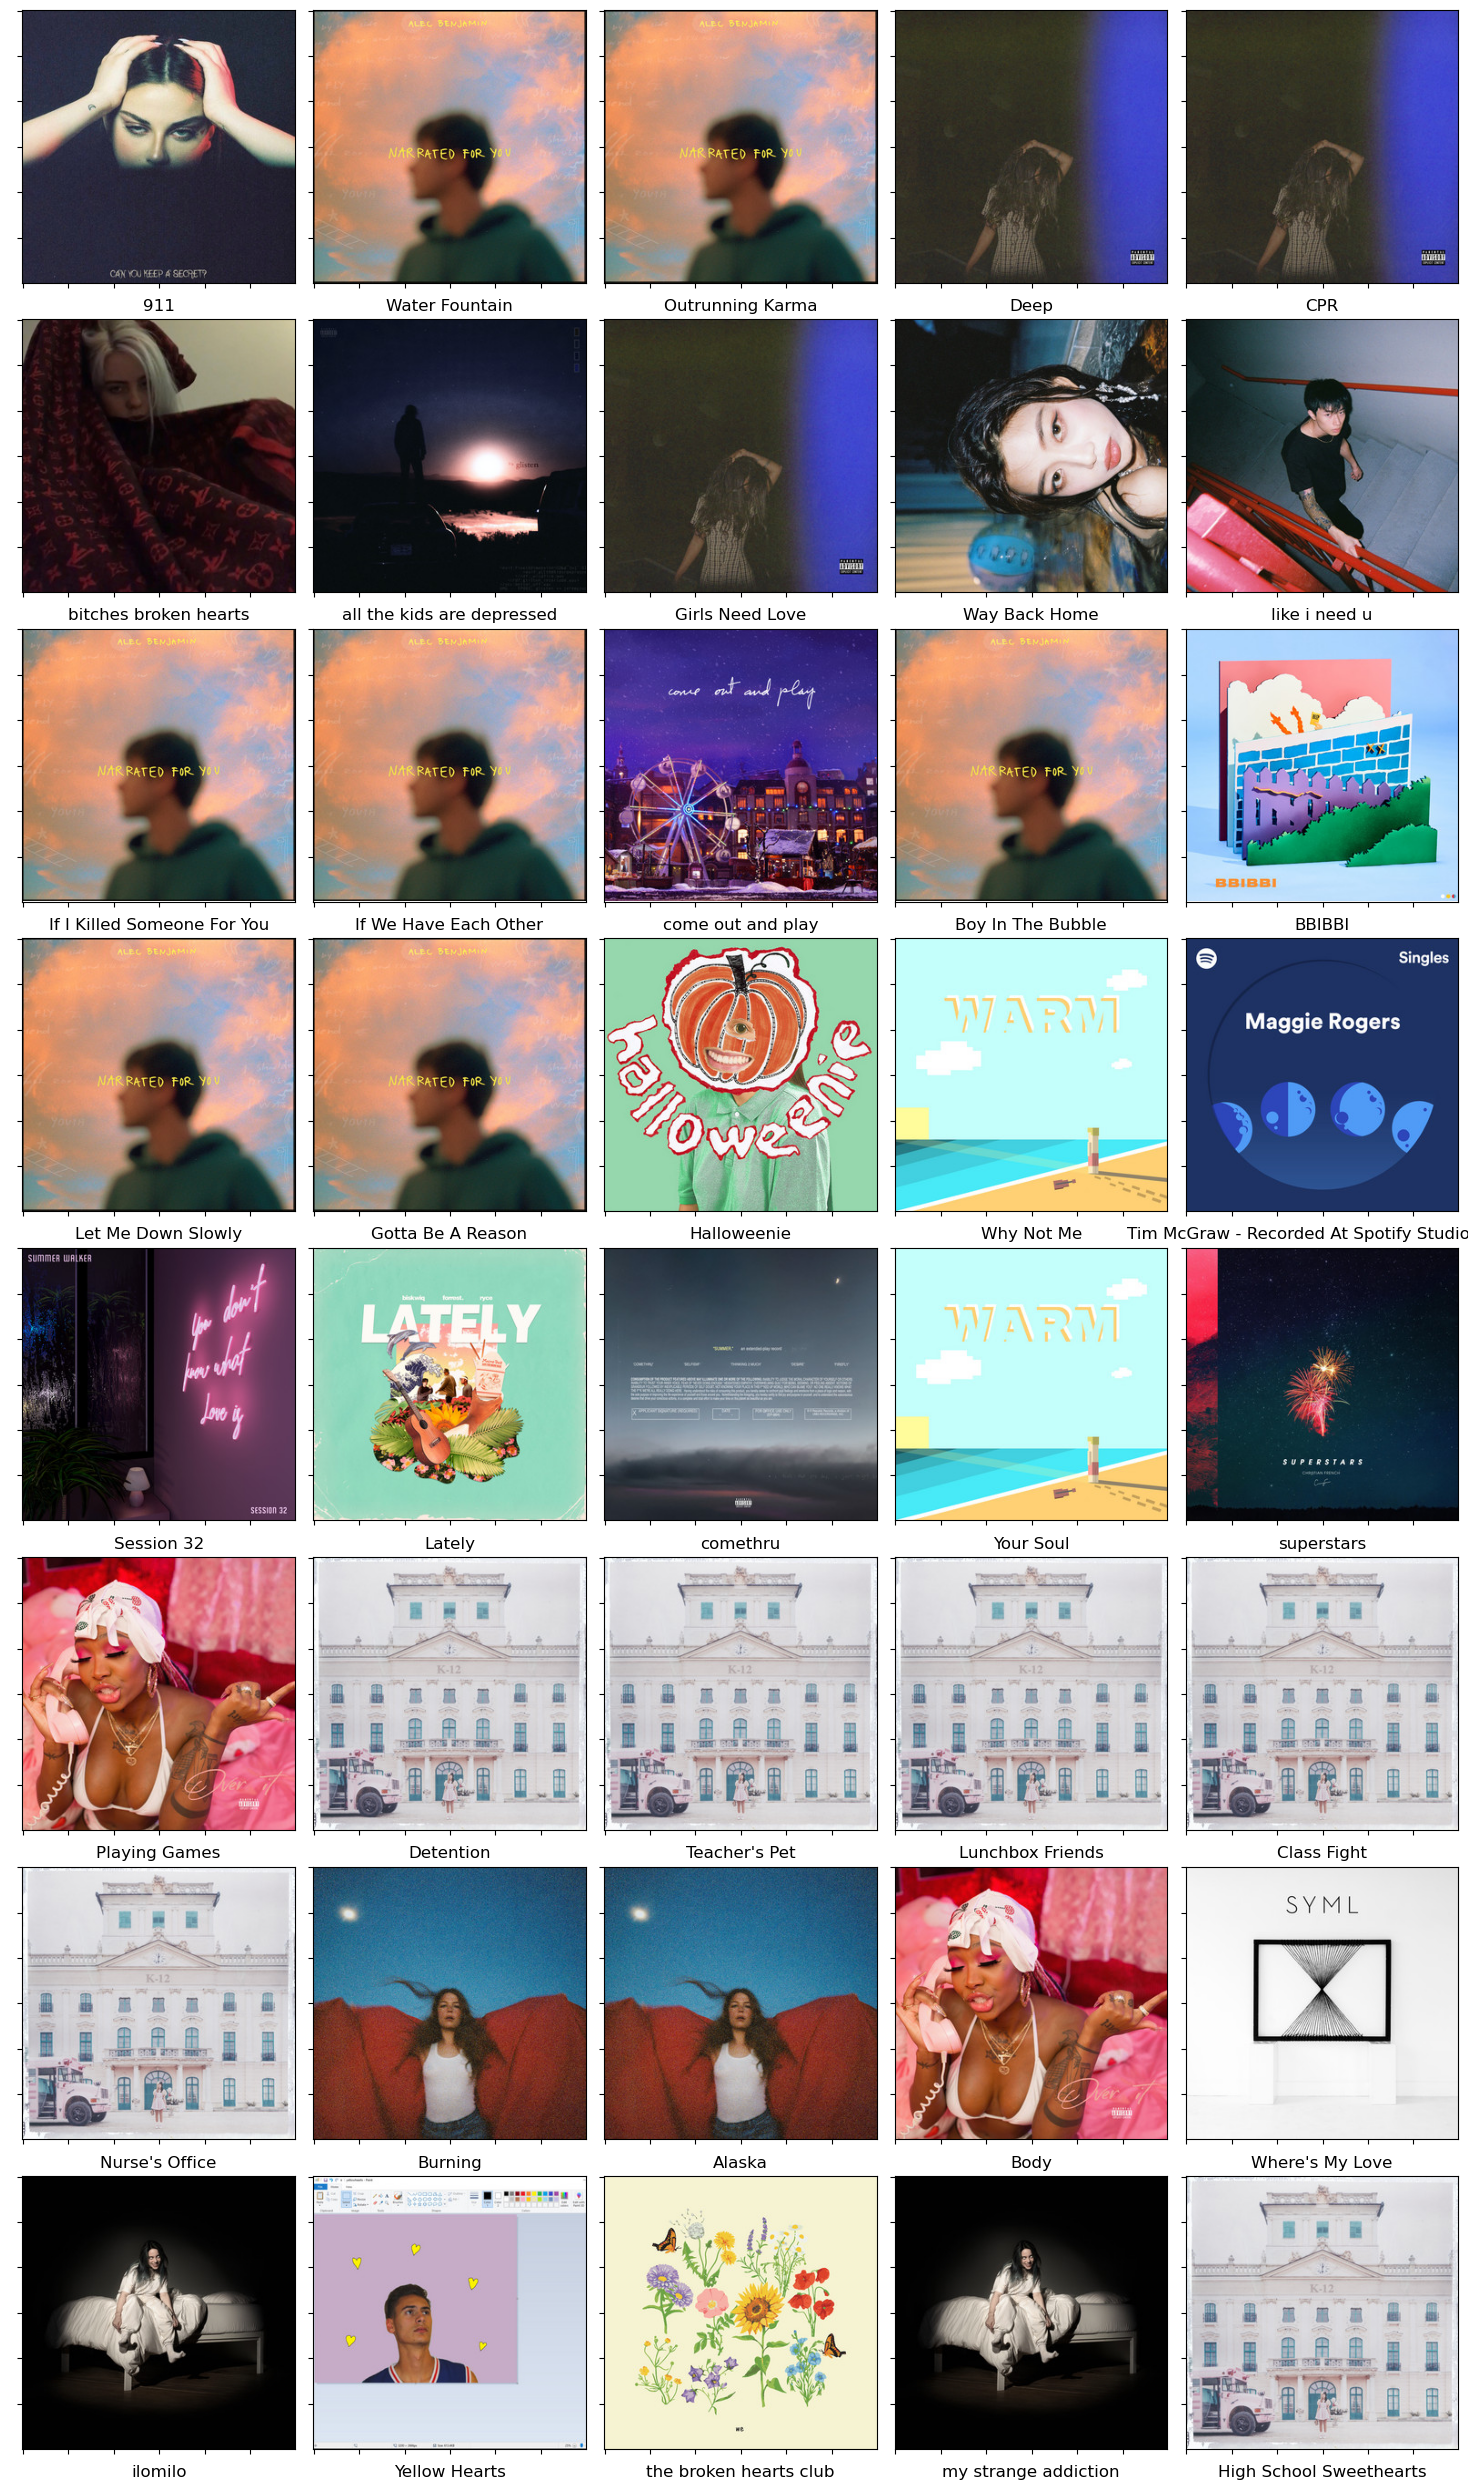

In [156]:
visualize_songs(edm_top40)